# Replication for results in Davidson et al. 2017. "Automated Hate Speech Detection and the Problem of Offensive Language"

Data retrieved from and classifier built based on repository for Thomas Davidson, Dana Warmsley, Michael Macy, and Ingmar Weber. 2017. "Automated Hate Speech Detection and the Problem of Offensive Language." ICWSM. https://github.com/t-davidson/hate-speech-and-offensive-language

In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
from datetime import datetime
%matplotlib inline

import helpers.hate_speech_detector as hsd

In [2]:
from importlib import reload

## Loading the data

In [3]:
df = pd.read_csv('data/labeled_data.csv')

In [4]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
df.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [6]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech.


offensive_language = number of CF users who judged the tweet to be offensive.


neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


class = class label for majority of CF users.

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text


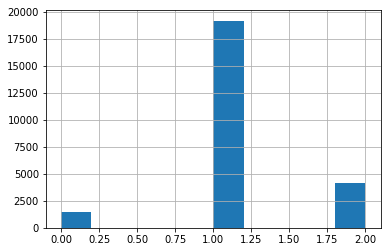

In [7]:
df['class'].hist()

This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were 
only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

## Build Classifier

In [8]:
df.tweet.head()

0    !!! RT @mayasolovely: As a woman you shouldn't...
1    !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2    !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3    !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4    !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
Name: tweet, dtype: object

In [9]:
%%time

reload(hsd)
model = hsd.HateSpeechClassifier()
X = df.tweet
y = df['class'].astype(int)
model.fit(df.tweet, df['class'].astype(int))

/home/dan/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/home/dan/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dan/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


CPU times: user 1min 47s, sys: 2.28 s, total: 1min 49s
Wall time: 1min 49s


# Running the model

The best model was selected using a GridSearch with 5-fold CV.

In [10]:
%%time

y_preds = model.predict(X)

CPU times: user 1min 41s, sys: 1.65 s, total: 1min 42s
Wall time: 1min 42s


## Evaluating the results

In [11]:
report = classification_report(y, y_preds)

***Note: Results in paper are from best model retrained on the entire dataset (see the other notebook). Here the results are reported after using cross-validation and only for the held-out set.***

In [12]:
print(report)

              precision    recall  f1-score   support

           0       0.40      0.45      0.42      1430
           1       0.94      0.87      0.90     19190
           2       0.66      0.83      0.74      4163

   micro avg       0.84      0.84      0.84     24783
   macro avg       0.66      0.72      0.69     24783
weighted avg       0.86      0.84      0.85     24783



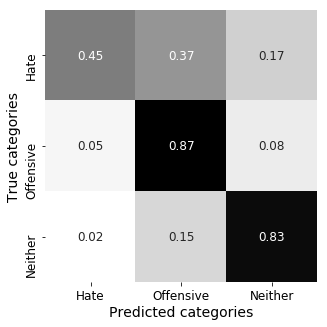

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y, y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

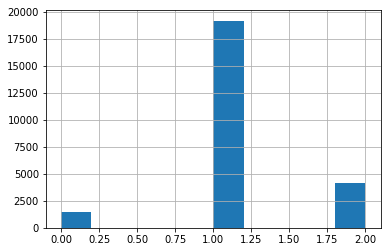

In [14]:
#True distribution
y.hist()

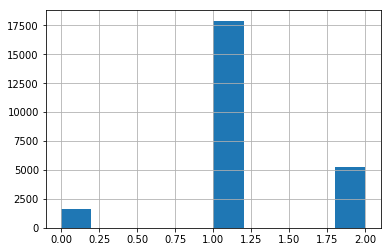

In [15]:
pd.Series(y_preds).hist()

In [16]:
from pickle import dump
now = datetime.now()
with open('HateSpeechClassifier.{}.pkl'.format(now.strftime('%Y%m%d-%H%M%S')), 'wb') as file:
    dump(model, file)

In [17]:
! ls -lah

total 1.4M
drwxrwxr-x 5 dan dan 4.0K Dec 11 01:42  .
drwxrwxr-x 7 dan dan 4.0K Dec 11 01:41  ..
drwxr-xr-x 2 dan dan 4.0K Dec 11 01:41  .ipynb_checkpoints
-rw-r--r-- 1 dan dan  27K Dec 11 01:41 'Build Hate Speech Classifier.ipynb'
-rw-r--r-- 1 dan dan 1.3M Dec 11 01:42  HateSpeechClassifier.20181211-014208.pkl
-rw-r--r-- 1 dan dan  13K Dec 11 01:41  TweetsFromKafka.ipynb
drwxrwxr-x 2 dan dan 4.0K Dec 11 01:39  data
drwxr-xr-x 4 dan dan 4.0K Dec 11 00:32  helpers
